In [1]:
import nltk
import pandas as pd

In [4]:
data = pd.read_csv('labeledTrainData.tsv', sep = '\t', index_col = 0)

In [5]:
data.head()

,sentiment,review
id,,
5814_8,1,With all this stuff going down at the moment w...
2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
7759_3,0,The film starts with a manager (Nicholas Bell)...
3630_4,0,It must be assumed that those who praised this...
9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
data['Length'] = data['review'].apply(len)

In [7]:
data.head()

,sentiment,review,Length
id,,,
5814_8,1,With all this stuff going down at the moment w...,2302
2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",946
7759_3,0,The film starts with a manager (Nicholas Bell)...,2449
3630_4,0,It must be assumed that those who praised this...,2245
9495_8,1,Superbly trashy and wondrously unpretentious 8...,2231


In [136]:
data[data['sentiment'] == 1]['sentiment'].value_counts()

1    12500
Name: sentiment, dtype: int64

In [137]:
data[data['sentiment'] == 0]['sentiment'].value_counts()

0    12500
Name: sentiment, dtype: int64

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

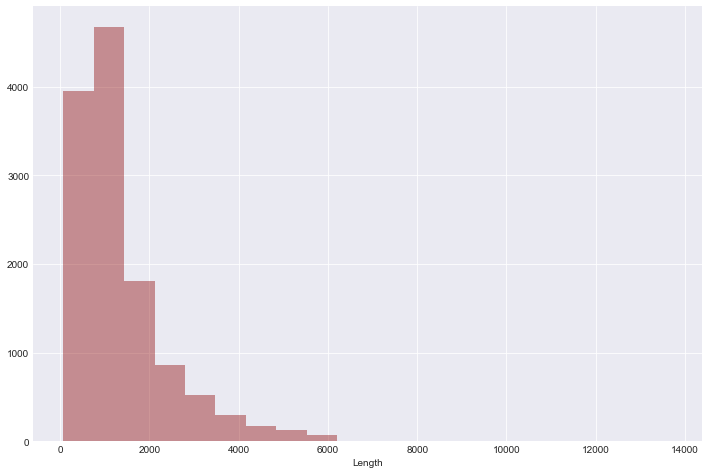

In [35]:
#data[data['sentiment'] == 1]['Length'].plot.hist(bins = 20)

plt.figure(figsize = (12,8))
sns.distplot(data[data['sentiment'] == 1]['Length'], bins = 20, color = 'darkred', kde = False)
#plt.ylim(0, 0.0006)

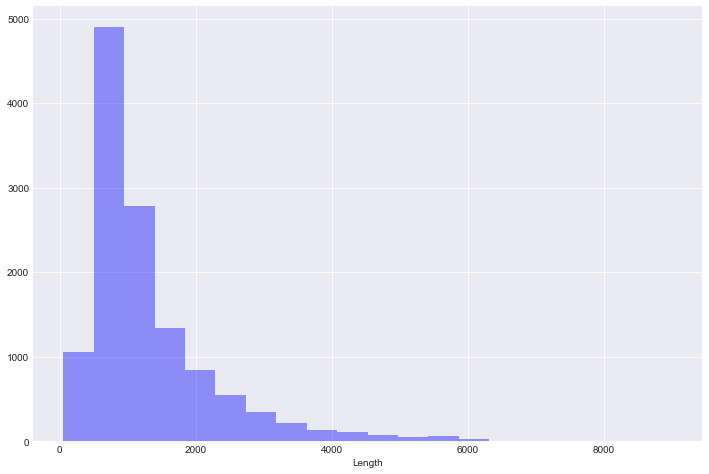

In [40]:
#data[data['sentiment'] == 0]['Length'].plot.hist(bins = 20)

plt.figure(figsize = (12,8))
sns.distplot(data[data['sentiment'] == 0]['Length'], bins = 20, color = 'blue', kde = False)

In [41]:
data['review'][0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [60]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

In [61]:
def review_to_words(raw_review):
    
   #remove the HTML tags
    remove_tags = BeautifulSoup(raw_review, 'lxml').get_text()
    
    #remove all the punctuations and numerical values
    nopunc = re.sub("[^a-zA-Z]", " ", remove_tags)
    
    #convert into lower case and split the sentence
    word = nopunc.lower().split()
    
    #convert the list of stopwords into set
    stops = set(stopwords.words('english'))
    
    #remove the stopwords
    clean_words = [w for w in word if not w in stops]
    
    #return the joined sentence
    return(' '.join(clean_words))

In [78]:
len_of_reviews = len(data['review'])
len_of_reviews

25000

In [79]:
clean_reviews = []

for i in range(len_of_reviews):
    clean_reviews.append(review_to_words(data['review'][i]))

# BAG OF WORDS

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
vectorizer = CountVectorizer(analyzer = review_to_words, max_features = 2000)

In [104]:
train_data_features = vectorizer.fit_transform(clean_reviews)

In [105]:
train_data_features = train_data_features.toarray()

In [106]:
train_data_features.shape

(25000, 27)

In [107]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(train_data_features)
tfidf = tfidf_transformer.transform(train_data_features)

# NAIVE BAYES

In [114]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(tfidf, data['sentiment'])

In [115]:
prediction = nb.predict(tfidf)

In [116]:
from sklearn.metrics import classification_report

print(classification_report(prediction, data['sentiment']))

             precision    recall  f1-score   support

          0       0.61      0.61      0.61     12340
          1       0.62      0.61      0.61     12660

avg / total       0.61      0.61      0.61     25000



# RANDOM FOREST

In [111]:
print ("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(tfidf, data["sentiment"] )

Training the random forest...


In [112]:
prediction_rf = forest.predict(tfidf)

In [113]:
from sklearn.metrics import classification_report

print(classification_report(prediction_rf, data['sentiment']))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12500
          1       1.00      1.00      1.00     12500

avg / total       1.00      1.00      1.00     25000



Looking at the above score the model is clearly overfit. And this was obvious since we evaluated the model on the same
data as the data which was used to train it. That is the reason we need two separate datsets for training and 
evaluating the model.

In [153]:
test = pd.read_csv('testData.tsv', index_col = 0, sep = "\t")

In [154]:
test.head()

,review
id,
12311_10,Naturally in a film who's main themes are of m...
8348_2,This movie is a disaster within a disaster fil...
5828_4,"All in all, this is a movie for kids. We saw i..."
7186_2,Afraid of the Dark left me with the impression...
12128_7,A very accurate depiction of small time mob li...


In [155]:
prediction_rf = forest.predict(test['review'])

ValueError: could not convert string to float: 'This is a great horror film for people who don\'t want all that vomit-retching gore and sensationalism. This movie has equal amounts of horror, suspense, humor, and even a little light nudity, but nothing big. Linnea Quigley isn\'t over the top as she was in \\Return of the Living Dead\\" where she danced naked on a crypt, but she is still essentially the same slutty character. Cathy Podewell is a virginal and chaste character before going on to \\"Dallas,\\" and we are also introduced to Amelia [soon Mimi] Kinkade,the sexy and sinister would-be dark matron of the house. As she and Linnea are possessed and take over the house, they reanimate the bodies of their dead friends to scare the limits out of the survivors. I\'ve heard a lot of people compare this movie to \\"The Evil Dead,\\" but if anything, this movie is a rival to that one the same way Freddie rivaled Jason.This movie series though is far superior to that one !"'